In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from datetime import date

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
image_dir = 'data/multipleplants'


species = ['Apple', 'Bell Pepper', 'Blueberry', 'Cherry (including sour)',
       'Corn (maize)', 'Grape', 'Orange', 'Peach', 'Potato', 'Raspberry',
       'Soybean', 'Squash', 'Strawberry', 'Tomato']

classes = ['Apple Black rot' 'Apple Cedar apple rust' 'Apple healthy' 'Apple scab'
 'Bell Pepper Bacterial spot' 'Bell Pepper healthy' 'Blueberry healthy'
 'Cherry (including sour) Powdery mildew'
 'Cherry (including sour) healthy'
 'Corn (maize) Cercospora leaf spot Gray leaf spot'
 'Corn (maize) Common rust ' 'Corn (maize) Northern Leaf Blight'
 'Corn (maize) healthy' 'Grape Black rot' 'Grape Esca (Black Measles)'
 'Grape Leaf blight (Isariopsis Leaf Spot)' 'Grape healthy'
 'Orange Haunglongbing (Citrus greening)' 'Peach Bacterial spot'
 'Peach healthy' 'Potato Early blight' 'Potato Late blight'
 'Potato healthy' 'Raspberry healthy' 'Soybean healthy'
 'Squash Powdery mildew' 'Strawberry Leaf scorch' 'Strawberry healthy'
 'Tomato American Serpentine Leafminer' 'Tomato Bacterial spot'
 'Tomato Early blight' 'Tomato Insect Bite' 'Tomato Late blight'
 'Tomato Leaf Mold' 'Tomato Powdery mildew' 'Tomato Septoria leaf spot'
 'Tomato Spider mites Two-spotted spider mite' 'Tomato Stem rot'
 'Tomato Target Spot' 'Tomato Wilt' 'Tomato Yellow Leaf Curl Virus'
 'Tomato healthy' 'Tomato mosaic virus']


tf.random.set_seed(1234)
np.random.seed(seed=1234)

In [12]:
# import image data and combine labels
def load_data(image_size=224, image_dir='data/multipleplants'):
    X = []
    y=[]
    labels =[]
    for root, folder, files in os.walk(image_dir):
        #print( folder)
        for f in files:
            #print(f)
            if f.lower().endswith('.jpg') or f.lower().endswith('.png') or f.lower().endswith('.jpeg'):
                #print(root, folder, f)
                img = load_img(f'{root}/{f}', target_size=(image_size,image_size,3))
                img_array = img_to_array(img, dtype='uint8')
                X.append(img_array)
                
                # get y
                specie, classname = root[20:].split('___')
                specie = specie.replace('_', ' ')
                classname = classname.replace('_', ' ')
                if classname[:len(specie)].lower() != specie.lower():
                    classname=specie +' ' + classname
                #print(species.index(specie), classes.index(classname))
                y.append([species.index(specie), classes.index(classname)])
                labels.append([specie, classname])
                
    return np.array(X, dtype=np.uint8), np.array(y), np.array(labels)

In [3]:
# import training data and combine labels
data_x, data_y, labels  = load_data() 

## Augmentation

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

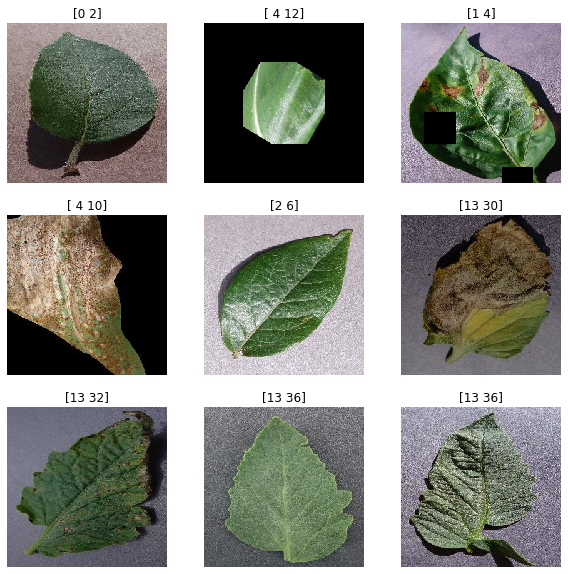

In [6]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [7]:
y_onehot = tf.one_hot(data_y[:,1], len(classes)).numpy()

In [8]:
x_train, x_val, y_train, y_val = train_test_split(data_x, y_onehot, test_size=0.05, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [9]:
len(x_train)

51856

In [10]:
len(x_val)

2730

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 38)                48678     
Total params: 4,098,249
Trainable params: 4,056,226
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/100
811/810 [==============================] - 190s 234ms/step - loss: 1.0262 - sparse_categorical_crossentropy: 2.1512 - val_loss: 0.3890 - val_sparse_categorical_crossentropy: 1.5269
Epoch 2/100
811/810 [======================

Epoch 39/100
811/810 [==============================] - 188s 232ms/step - loss: 0.0753 - sparse_categorical_crossentropy: 1.4954 - val_loss: 0.0535 - val_sparse_categorical_crossentropy: 1.4993
Epoch 40/100
811/810 [==============================] - 188s 232ms/step - loss: 0.0742 - sparse_categorical_crossentropy: 1.4932 - val_loss: 0.0514 - val_sparse_categorical_crossentropy: 1.4984
Epoch 41/100
811/810 [==============================] - 188s 232ms/step - loss: 0.0755 - sparse_categorical_crossentropy: 1.4892 - val_loss: 0.0508 - val_sparse_categorical_crossentropy: 1.5001
Epoch 42/100
811/810 [==============================] - 188s 232ms/step - loss: 0.0698 - sparse_categorical_crossentropy: 1.4857 - val_loss: 0.0497 - val_sparse_categorical_crossentropy: 1.4956
Epoch 43/100
811/810 [==============================] - 188s 232ms/step - loss: 0.0708 - sparse_categorical_crossentropy: 1.4932 - val_loss: 0.0504 - val_sparse_categorical_crossentropy: 1.4945
Epoch 44/100
811/810 [========

811/810 [==============================] - 263s 324ms/step - loss: 0.0738 - sparse_categorical_crossentropy: 1.3823 - val_loss: 0.0546 - val_sparse_categorical_crossentropy: 1.3470
Epoch 51/100
811/810 [==============================] - 263s 324ms/step - loss: 0.0735 - sparse_categorical_crossentropy: 1.3773 - val_loss: 0.0561 - val_sparse_categorical_crossentropy: 1.3454
Epoch 52/100
811/810 [==============================] - 263s 324ms/step - loss: 0.0731 - sparse_categorical_crossentropy: 1.3700 - val_loss: 0.0555 - val_sparse_categorical_crossentropy: 1.3418
Epoch 53/100
811/810 [==============================] - 263s 324ms/step - loss: 0.0740 - sparse_categorical_crossentropy: 1.3780 - val_loss: 0.0552 - val_sparse_categorical_crossentropy: 1.3408
Epoch 54/100
811/810 [==============================] - 263s 324ms/step - loss: 0.0734 - sparse_categorical_crossentropy: 1.3707 - val_loss: 0.0546 - val_sparse_categorical_crossentropy: 1.3424
Epoch 55/100
811/810 [=====================

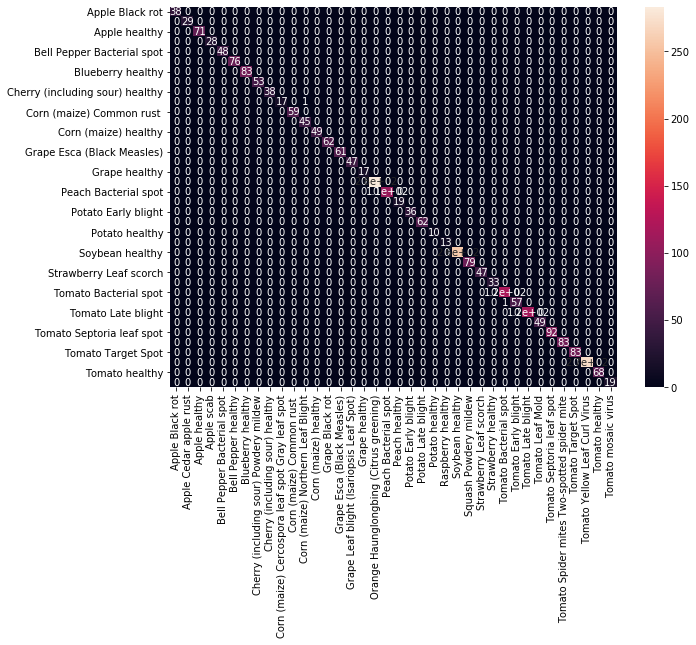

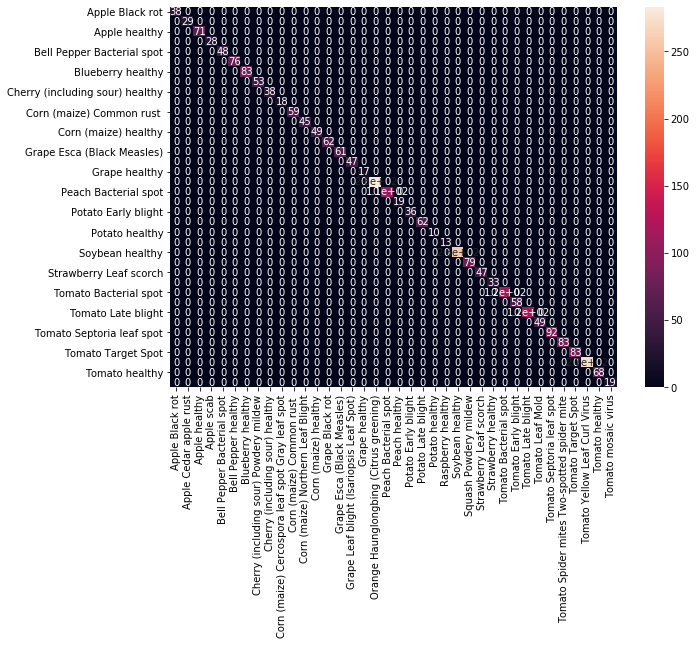

In [21]:
from tensorflow.keras import applications
import logging
logging.basicConfig(filename='EfficientNet-AutoML.log')

model_list = ['EfficientNetB0', 'EfficientNetB1']

for m in model_list:
    base_model = getattr(applications , m)(weights='imagenet', input_shape=(image_size, image_size, 3),  include_top=False)

    # Create new model on top.
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(38)(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    
    
    # Warm up head
    adam = optimizers.Adam(learning_rate=0.0005)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.2,  
                               patience=3, 
                               min_lr=0.00005)
    early_stop = EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=6, 
        verbose=0, 
        mode='auto',
        baseline=None, 
        restore_best_weights=True
    )

    batch_size = 64
    #num_warmup_steps = 5

    # freeze pretrained weights
    model.layers[1].trainable = False

    model.compile(optimizer=adam, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


    history = model.fit(generator(x_train, y_train, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=100,
                        steps_per_epoch=len(x_train)/batch_size ,
                        verbose=True
                       )
    print(model.optimizer.lr)
    
    # Train entire network
    adam = optimizers.Adam(learning_rate=0.0001)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                               factor=0.2,  
                               patience=5 , 
                               min_lr=0.00001)
    early_stop = EarlyStopping(
        monitor='val_accuracy', 
        min_delta=0, 
        patience=10, 
        verbose=0, 
        mode='auto',
        baseline=None, 
        restore_best_weights=True
    )

    # freeze pretrained weights
    model.layers[1].trainable = True

    model.compile(optimizer=adam, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history2 = model.fit(generator(x_train, y_train, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=200,
                        steps_per_epoch=len(x_train)/batch_size ,
                        verbose=True
                       )
    model.save(f'models/{m}')
    from sklearn.metrics import confusion_matrix
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt

    y_val_pred = np.argmax(model.predict(x_val), axis=1)
    mat = confusion_matrix(y_val, y_val_pred)

    df_cm = pd.DataFrame(mat, index = [i for i in classes],
                      columns = [i for i in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    

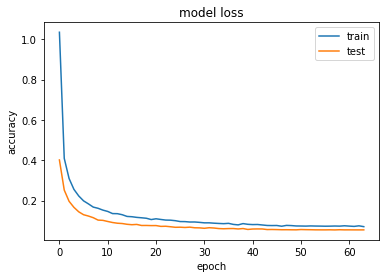

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

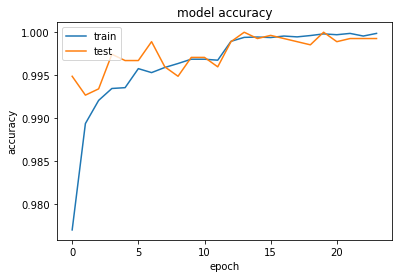

In [23]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()